By Drilon & Chia-Hua

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as torchfunc
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

/home/shubuni/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Loading Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data),len(validation_data),len(test_data))
print(training_data[0][0].shape)

50000 10000 10000
torch.Size([1, 28, 28])


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [21]:
def cnn_model():
    """
    Model with two CNN layers, one dense and an output classification layer, with suitable number of filters and units, respectively.
    :return:
    """
    ### YOUR CODE HERE
    class CNNModel(torch.nn.Module):
        def __init__(self, num_classes=10):
            super(CNNModel, self).__init__()
            self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
            self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.fc1 = torch.nn.Linear(64 * 7 * 7, num_classes)
    
        def forward(self, x):
            x = self.pool(torchfunc.relu(self.conv1(x)))
            x = self.pool(torchfunc.relu(self.conv2(x)))
            x = x.view(-1, 64 * 7 * 7)
            x = self.fc1(x)
            return x


    ### YOUR CODE HERE
    return CNNModel()

In [22]:
model = cnn_model()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.19
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [23]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):

        ### YOUR CODE HERE ###
        model.train()
        train_total = 0
        count_train = 0
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
            train_total += Y.size(0)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count_train += 1

        if scheduler:
            scheduler.step()
        
        cost /= count_train
        acc = acc / train_total

        cost_test, test_correct = 0, 0
        count_test = 0
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                loss = cost_ce(pred, Y)

                cost_test += loss.item()
                test_correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
                count_test += 1
        
        cost_test /= count_test
        acc_test = test_correct / len(test_loader.dataset)

        print(f"Epoch {epoch}: Train Loss: {cost:.4f}, Train Acc: {acc:.4f}, Test Loss: {cost_test:.4f}, Test Acc: {acc_test:.4f}")

        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

In [24]:
def plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(cost_hist, label='Training cost')
    ax1.plot(cost_hist_test, label='Testing cost')
    ax1.legend()
    ax1.grid()
    ax2.plot(acc_hist, label='Training accuracy')
    ax2.plot(acc_hist_test, label='Test accuracy')
    ax2.legend()
    ax2.grid()

Epoch 0: Train Loss: 0.5831, Train Acc: 0.7938, Test Loss: 0.4857, Test Acc: 0.8095
Epoch 1: Train Loss: 0.3721, Train Acc: 0.8683, Test Loss: 0.4473, Test Acc: 0.8407
Epoch 2: Train Loss: 0.3261, Train Acc: 0.8840, Test Loss: 0.3411, Test Acc: 0.8796
Epoch 3: Train Loss: 0.2970, Train Acc: 0.8949, Test Loss: 0.3879, Test Acc: 0.8669
Epoch 4: Train Loss: 0.2767, Train Acc: 0.9006, Test Loss: 0.2846, Test Acc: 0.8979
Epoch 5: Train Loss: 0.2613, Train Acc: 0.9061, Test Loss: 0.3783, Test Acc: 0.8678
Epoch 6: Train Loss: 0.2476, Train Acc: 0.9108, Test Loss: 0.2655, Test Acc: 0.9050
Epoch 7: Train Loss: 0.2344, Train Acc: 0.9159, Test Loss: 0.2759, Test Acc: 0.9010
Epoch 8: Train Loss: 0.2257, Train Acc: 0.9196, Test Loss: 0.2578, Test Acc: 0.9061
Epoch 9: Train Loss: 0.2162, Train Acc: 0.9221, Test Loss: 0.2904, Test Acc: 0.8979


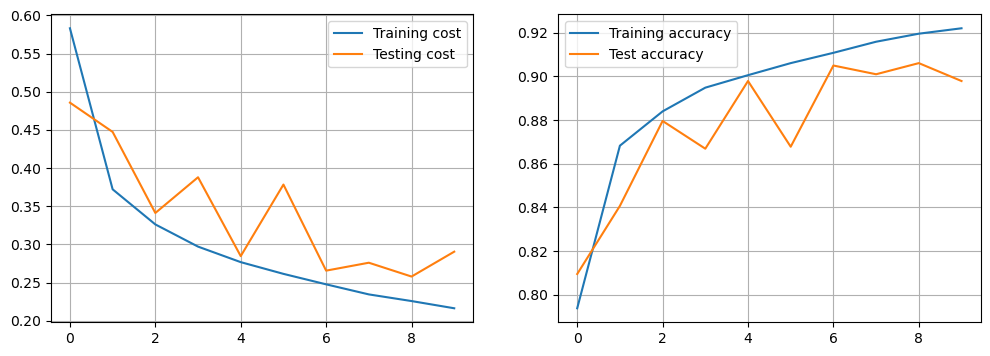

In [27]:
from torch import optim

batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.1
nepochs = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)

plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test)

Epoch 0: Train Loss: 0.6751, Train Acc: 0.7637, Test Loss: 0.4482, Test Acc: 0.8389
Epoch 1: Train Loss: 0.4152, Train Acc: 0.8522, Test Loss: 0.5276, Test Acc: 0.8047
Epoch 2: Train Loss: 0.3691, Train Acc: 0.8683, Test Loss: 0.3943, Test Acc: 0.8557
Epoch 3: Train Loss: 0.3362, Train Acc: 0.8809, Test Loss: 0.4823, Test Acc: 0.8211
Epoch 4: Train Loss: 0.3176, Train Acc: 0.8863, Test Loss: 0.4377, Test Acc: 0.8367
Epoch 5: Train Loss: 0.3004, Train Acc: 0.8936, Test Loss: 0.3072, Test Acc: 0.8882
Epoch 6: Train Loss: 0.2874, Train Acc: 0.8975, Test Loss: 0.4049, Test Acc: 0.8482
Epoch 7: Train Loss: 0.2750, Train Acc: 0.9016, Test Loss: 0.3066, Test Acc: 0.8907
Epoch 8: Train Loss: 0.2656, Train Acc: 0.9055, Test Loss: 0.2931, Test Acc: 0.8947
Epoch 9: Train Loss: 0.2576, Train Acc: 0.9086, Test Loss: 0.3989, Test Acc: 0.8560


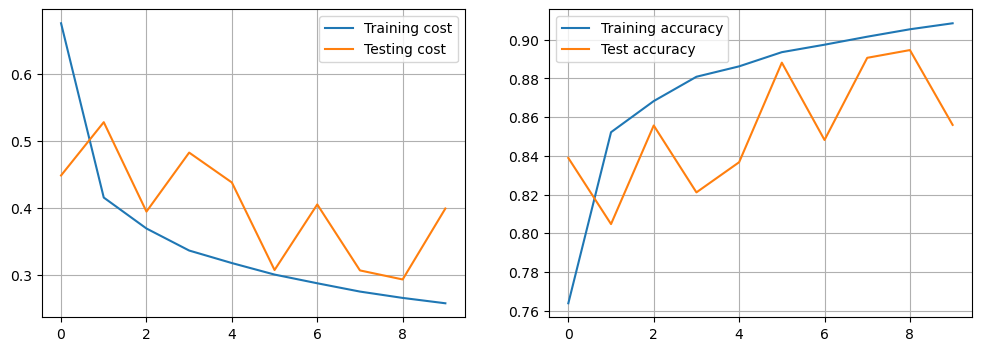

In [28]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.05
nepochs = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)

plot_performance(cost_hist, cost_hist_test, acc_hist, acc_hist_test)

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


In [30]:
from sklearn.model_selection import KFold

nepochs = 10

model = cnn_model()

training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
kfold = KFold(n_splits=5, shuffle=True)

accuracies = []
losses = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(training_data)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(training_data, batch_size=64, sampler=val_subsampler)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

    train_loss, val_loss, train_acc, val_acc = train_eval(model, optimizer, nepochs, train_loader, val_loader)

    accuracies.extend(val_acc)
    losses.extend(val_loss)
    print(f'Validation accuracy for fold {fold}: {val_acc[-1]:.4f}')
    print('--------------------------------')

average_accuracy = np.mean(accuracies)
std_deviation_accuracy = np.std(accuracies)

print(f'5-Fold Cross-Validation Accuracy: {average_accuracy:.4f} ± {std_deviation_accuracy:.4f}')

FOLD 0
--------------------------------
Epoch 0: Train Loss: 0.6728, Train Acc: 0.7614, Test Loss: 0.4407, Test Acc: 0.1685
Epoch 1: Train Loss: 0.4239, Train Acc: 0.8494, Test Loss: 0.3709, Test Acc: 0.1741


KeyboardInterrupt: 

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [31]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.05
nepochs = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=False)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)
momentum_no_nesterov = [cost_hist, cost_hist_test, acc_hist, acc_hist_test]

Epoch 0: Train Loss: 0.4336, Train Acc: 0.8451, Test Loss: 0.3121, Test Acc: 0.8946
Epoch 1: Train Loss: 0.2936, Train Acc: 0.8949, Test Loss: 0.2529, Test Acc: 0.9090
Epoch 2: Train Loss: 0.2591, Train Acc: 0.9075, Test Loss: 0.2266, Test Acc: 0.9146
Epoch 3: Train Loss: 0.2455, Train Acc: 0.9122, Test Loss: 0.2479, Test Acc: 0.9078
Epoch 4: Train Loss: 0.2293, Train Acc: 0.9173, Test Loss: 0.1999, Test Acc: 0.9278
Epoch 5: Train Loss: 0.2235, Train Acc: 0.9190, Test Loss: 0.1874, Test Acc: 0.9321
Epoch 6: Train Loss: 0.2101, Train Acc: 0.9232, Test Loss: 0.1774, Test Acc: 0.9371
Epoch 7: Train Loss: 0.1956, Train Acc: 0.9288, Test Loss: 0.1828, Test Acc: 0.9361
Epoch 8: Train Loss: 0.1953, Train Acc: 0.9296, Test Loss: 0.1717, Test Acc: 0.9333
Epoch 9: Train Loss: 0.1903, Train Acc: 0.9304, Test Loss: 0.1879, Test Acc: 0.9308


In [32]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.1
nepochs = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)
momentum_with_nesterov = [cost_hist, cost_hist_test, acc_hist, acc_hist_test]

Epoch 0: Train Loss: 0.4204, Train Acc: 0.8506, Test Loss: 0.3100, Test Acc: 0.8878
Epoch 1: Train Loss: 0.3211, Train Acc: 0.8847, Test Loss: 0.3094, Test Acc: 0.8861
Epoch 2: Train Loss: 0.3044, Train Acc: 0.8899, Test Loss: 0.3241, Test Acc: 0.8848
Epoch 3: Train Loss: 0.2931, Train Acc: 0.8937, Test Loss: 0.2754, Test Acc: 0.8959
Epoch 4: Train Loss: 0.2853, Train Acc: 0.8955, Test Loss: 0.2415, Test Acc: 0.9116
Epoch 5: Train Loss: 0.2746, Train Acc: 0.9013, Test Loss: 0.2570, Test Acc: 0.9052
Epoch 6: Train Loss: 0.2680, Train Acc: 0.9031, Test Loss: 0.2889, Test Acc: 0.8974
Epoch 7: Train Loss: 0.2627, Train Acc: 0.9047, Test Loss: 0.2416, Test Acc: 0.9129
Epoch 8: Train Loss: 0.2537, Train Acc: 0.9083, Test Loss: 0.2495, Test Acc: 0.9065
Epoch 9: Train Loss: 0.2536, Train Acc: 0.9074, Test Loss: 0.2410, Test Acc: 0.9137


In [33]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.05
nepochs = 10

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, centered=False)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)
default_RMS_prop = [cost_hist, cost_hist_test, acc_hist, acc_hist_test]

Epoch 0: Train Loss: 14.5333, Train Acc: 0.7218, Test Loss: 0.7963, Test Acc: 0.7550
Epoch 1: Train Loss: 0.5928, Train Acc: 0.8087, Test Loss: 0.4669, Test Acc: 0.8344
Epoch 2: Train Loss: 0.5000, Train Acc: 0.8174, Test Loss: 0.5037, Test Acc: 0.8083
Epoch 3: Train Loss: 0.5254, Train Acc: 0.8200, Test Loss: 0.5977, Test Acc: 0.7765
Epoch 4: Train Loss: 0.4874, Train Acc: 0.8198, Test Loss: 0.4897, Test Acc: 0.8062
Epoch 5: Train Loss: 0.4850, Train Acc: 0.8216, Test Loss: 0.5018, Test Acc: 0.8174
Epoch 6: Train Loss: 0.4854, Train Acc: 0.8221, Test Loss: 0.4720, Test Acc: 0.8271
Epoch 7: Train Loss: 0.6569, Train Acc: 0.7858, Test Loss: 0.7398, Test Acc: 0.7372
Epoch 8: Train Loss: 0.6347, Train Acc: 0.7743, Test Loss: 0.5679, Test Acc: 0.7891
Epoch 9: Train Loss: 0.5475, Train Acc: 0.8016, Test Loss: 0.5497, Test Acc: 0.7964


In [34]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.05
nepochs = 10

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.5, centered=True)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)
test_RMS_prop = [cost_hist, cost_hist_test, acc_hist, acc_hist_test]

Epoch 0: Train Loss: 1.2698, Train Acc: 0.7518, Test Loss: 0.6551, Test Acc: 0.7796
Epoch 1: Train Loss: 0.7105, Train Acc: 0.7784, Test Loss: 0.8697, Test Acc: 0.7512
Epoch 2: Train Loss: 0.7419, Train Acc: 0.7697, Test Loss: 0.6999, Test Acc: 0.7622
Epoch 3: Train Loss: 0.7791, Train Acc: 0.7641, Test Loss: 0.8348, Test Acc: 0.7358
Epoch 4: Train Loss: 0.8543, Train Acc: 0.7461, Test Loss: 0.6672, Test Acc: 0.7602
Epoch 5: Train Loss: 1.6806, Train Acc: 0.3748, Test Loss: 2.3209, Test Acc: 0.1011
Epoch 6: Train Loss: 2.3107, Train Acc: 0.0973, Test Loss: 2.3106, Test Acc: 0.1001
Epoch 7: Train Loss: 2.3106, Train Acc: 0.1019, Test Loss: 2.3073, Test Acc: 0.1011
Epoch 8: Train Loss: 2.3107, Train Acc: 0.1020, Test Loss: 2.3108, Test Acc: 0.0962
Epoch 9: Train Loss: 2.3104, Train Acc: 0.1001, Test Loss: 2.3098, Test Acc: 0.0982


In [35]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.05
nepochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)
default_adam = [cost_hist, cost_hist_test, acc_hist, acc_hist_test]

Epoch 0: Train Loss: 0.7313, Train Acc: 0.7598, Test Loss: 0.5023, Test Acc: 0.8148
Epoch 1: Train Loss: 0.5445, Train Acc: 0.8060, Test Loss: 0.5325, Test Acc: 0.8001
Epoch 2: Train Loss: 0.5556, Train Acc: 0.8020, Test Loss: 0.5165, Test Acc: 0.8110
Epoch 3: Train Loss: 0.5318, Train Acc: 0.8100, Test Loss: 0.5014, Test Acc: 0.8160
Epoch 4: Train Loss: 0.5290, Train Acc: 0.8097, Test Loss: 0.4918, Test Acc: 0.8173
Epoch 5: Train Loss: 0.5331, Train Acc: 0.8097, Test Loss: 0.5163, Test Acc: 0.8148
Epoch 6: Train Loss: 0.5363, Train Acc: 0.8098, Test Loss: 0.5206, Test Acc: 0.8144
Epoch 7: Train Loss: 0.5346, Train Acc: 0.8092, Test Loss: 0.5169, Test Acc: 0.8056
Epoch 8: Train Loss: 0.5334, Train Acc: 0.8089, Test Loss: 0.5189, Test Acc: 0.8094
Epoch 9: Train Loss: 0.5365, Train Acc: 0.8075, Test Loss: 0.5197, Test Acc: 0.8153


In [36]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model = cnn_model()

learning_rate = 0.05
nepochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), eps=1e-08, weight_decay=0)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, test_loader)
test_adam = [cost_hist, cost_hist_test, acc_hist, acc_hist_test]

Epoch 0: Train Loss: 1.2266, Train Acc: 0.6021, Test Loss: 2.3110, Test Acc: 0.0982
Epoch 1: Train Loss: 2.3077, Train Acc: 0.0990, Test Loss: 2.3052, Test Acc: 0.0982
Epoch 2: Train Loss: 2.3074, Train Acc: 0.0983, Test Loss: 2.3151, Test Acc: 0.0982
Epoch 3: Train Loss: 2.3071, Train Acc: 0.1003, Test Loss: 2.3125, Test Acc: 0.1011
Epoch 4: Train Loss: 2.3072, Train Acc: 0.1006, Test Loss: 2.3049, Test Acc: 0.1020
Epoch 5: Train Loss: 2.3072, Train Acc: 0.1002, Test Loss: 2.3071, Test Acc: 0.1011
Epoch 6: Train Loss: 2.3077, Train Acc: 0.0980, Test Loss: 2.3089, Test Acc: 0.1002
Epoch 7: Train Loss: 2.3076, Train Acc: 0.0999, Test Loss: 2.3060, Test Acc: 0.0991
Epoch 8: Train Loss: 2.3073, Train Acc: 0.0988, Test Loss: 2.3044, Test Acc: 0.1009
Epoch 9: Train Loss: 2.3069, Train Acc: 0.0993, Test Loss: 2.3088, Test Acc: 0.1009


### Plots and Comments (for the different steps described above) 

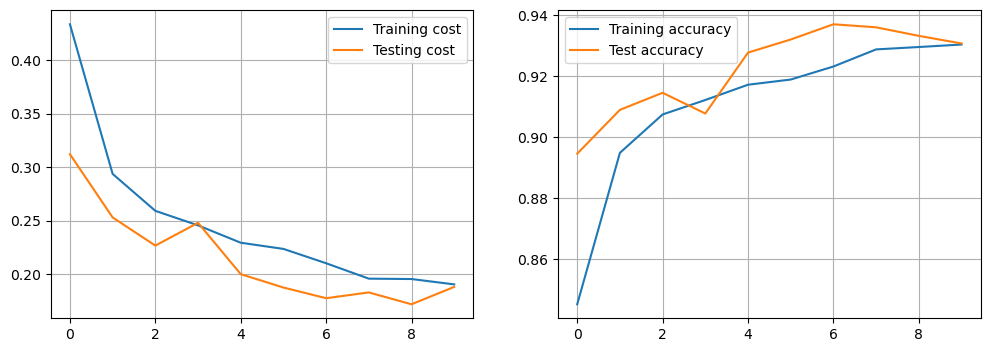

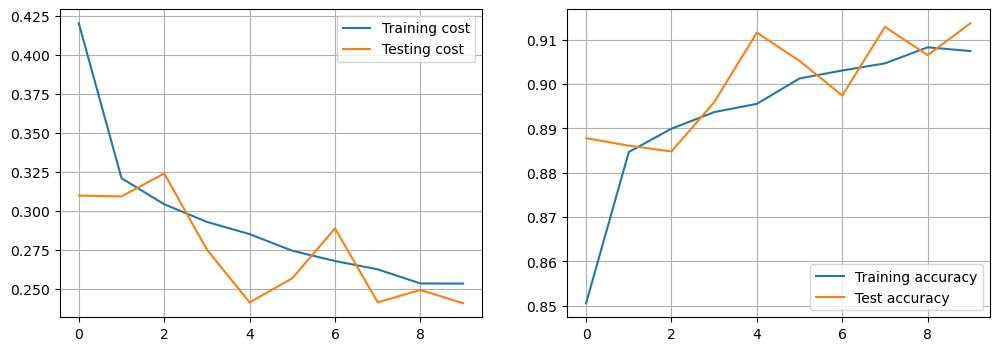

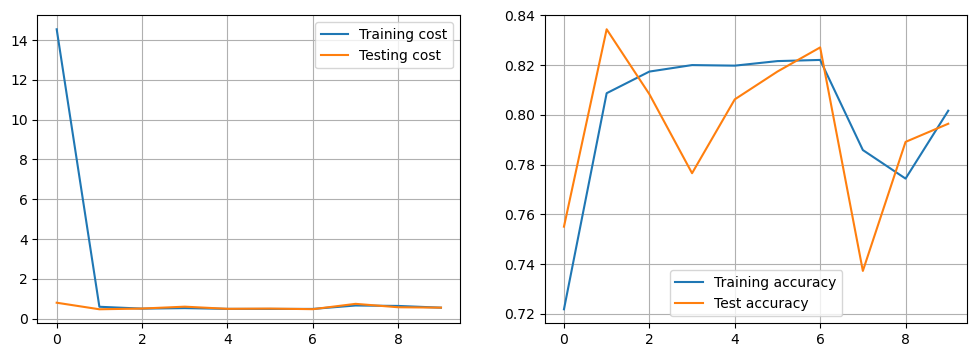

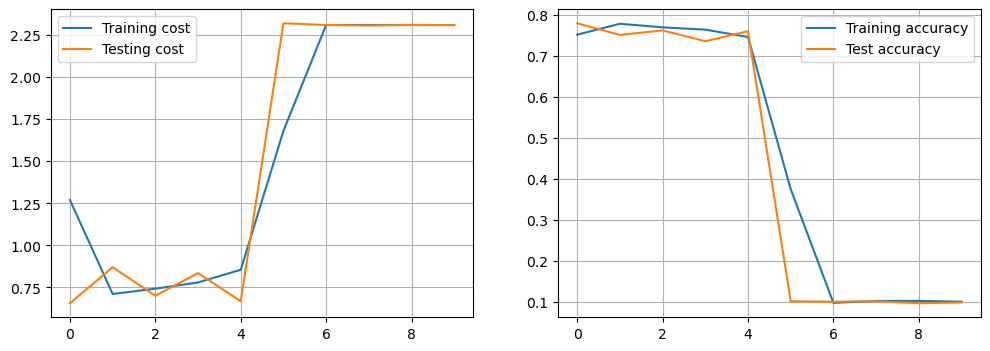

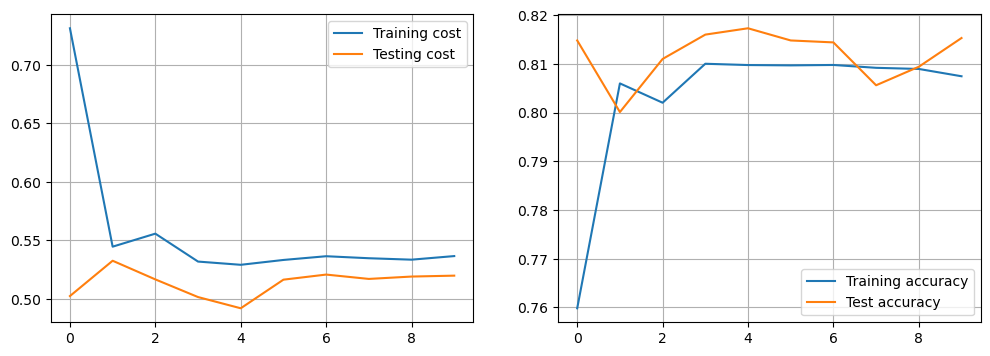

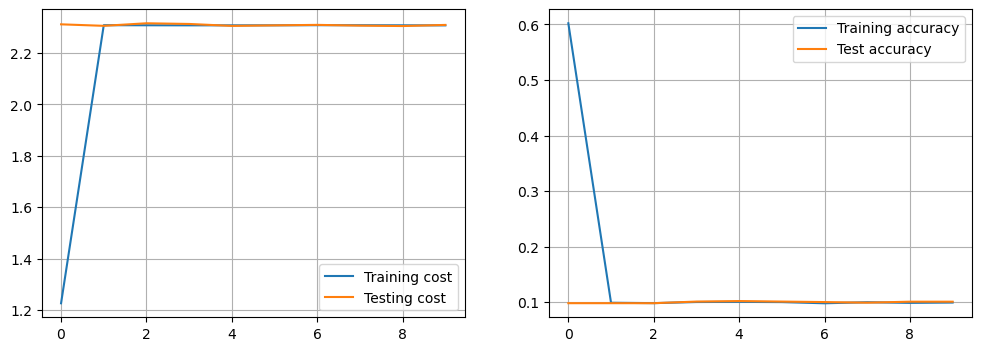

In [37]:
plot_performance(*momentum_no_nesterov)
plot_performance(*momentum_with_nesterov)
plot_performance(*default_RMS_prop)
plot_performance(*test_RMS_prop)
plot_performance(*default_adam)
plot_performance(*test_adam)

## Results
Plots are as follows:
plot_performance(*momentum_no_nesterov)
plot_performance(*momentum_with_nesterov)
plot_performance(*default_RMS_prop)
plot_performance(*test_RMS_prop)
plot_performance(*default_adam)
plot_performance(*test_adam)

We got some interesting results. We would need to tweak the hyperparameters a and test again because with some arguments we see than it didn't converge and the loss and accuracy got worse. Especially when we didn't use the default values as in adam and RMS Prop Optimization. The others look quite nice for training only 10 epochs!


### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.